In [177]:
from re import search
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import metrics

from sklearn.svm import LinearSVC


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#### Import Data

In [178]:
df = pd.read_csv("../Data/kidneyData.csv", encoding='latin1', low_memory=False)

#### Helper functions

In [180]:
def print_df_percent_missing(df_passed):
    col_names = list(df_passed.columns.values)
    tuples_of_missing = []
    num_rows = df_passed.shape[0]


    i = 0
    for value in df_passed.count():
        tuples_of_missing.append((col_names[i], value))
        i+=1

    tuples_of_missing.sort(key=lambda pair: pair[1], reverse=False)

    i = 1
    for key, value in tuples_of_missing: 
        percent_missing = 100 - (value / num_rows * 100)
        print(key.ljust(30),  str(f'{percent_missing:.2f}' + '%').ljust(6) + " Missing   " + str(i))
        i += 1

### Changing to a Binary Problem

In [181]:
def convert_mismatch_to_binary(x):
    if x <= 1:
        return 1
    else:
        return 0

df["misMatches_binary"] = df["misMatches"].apply(convert_mismatch_to_binary)

Binary = df.drop('misMatches', axis=1)

In [281]:
df.shape

(158509, 624)

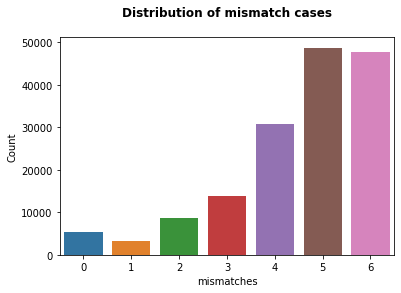

In [234]:
fig=sns.countplot(x='misMatches', data=df)
plt.title('Distribution of mismatch cases\n',fontweight="bold")
plt.xlabel('mismatches')
plt.ylabel('Count')
plt.savefig('misMatches.png')

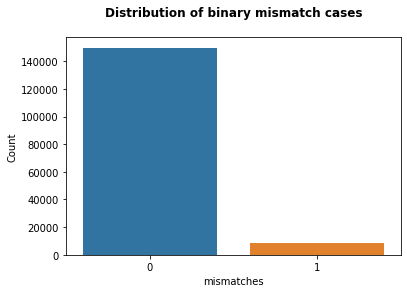

In [235]:
sns.countplot(x=df["misMatches_binary"], data=df)
plt.title('Distribution of binary mismatch cases\n',fontweight="bold")
plt.xlabel('mismatches')
plt.ylabel('Count')
plt.savefig('BinmisMatches.png')

/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


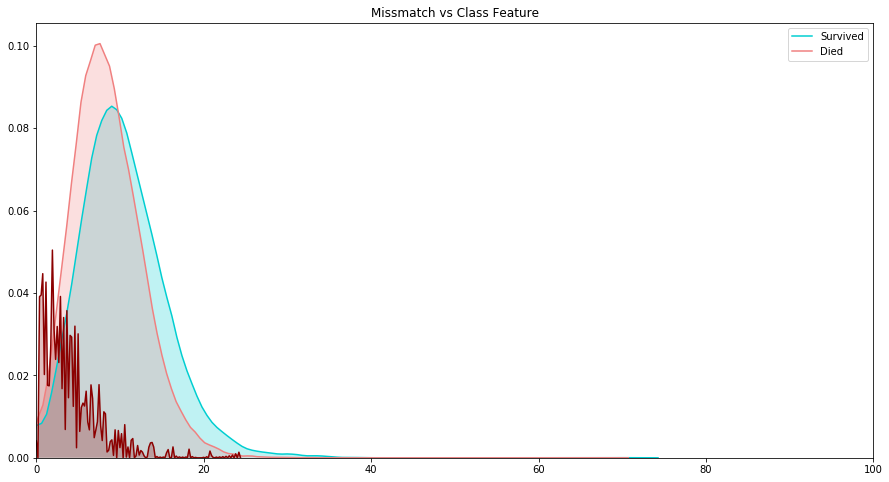

In [183]:
df["misMatches_binary"]
plt.figure(figsize=(15,8))
#sns.kdeplot(df.Avg_EMS[df["misMatches_binary"]], color="darkturquoise",  shade=True)
sns.kdeplot(df.Avg_EMS[df["misMatches"] == 6], color="darkturquoise",  shade=True)
sns.kdeplot(df.Avg_EMS[df["misMatches"] == 5], color="lightcoral", shade=True)
sns.kdeplot(df.Avg_EMS[df["misMatches"] == 0], color="darkred", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Missmatch vs Class Feature')
plt.xlim(0,100)
plt.show()

/usr/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


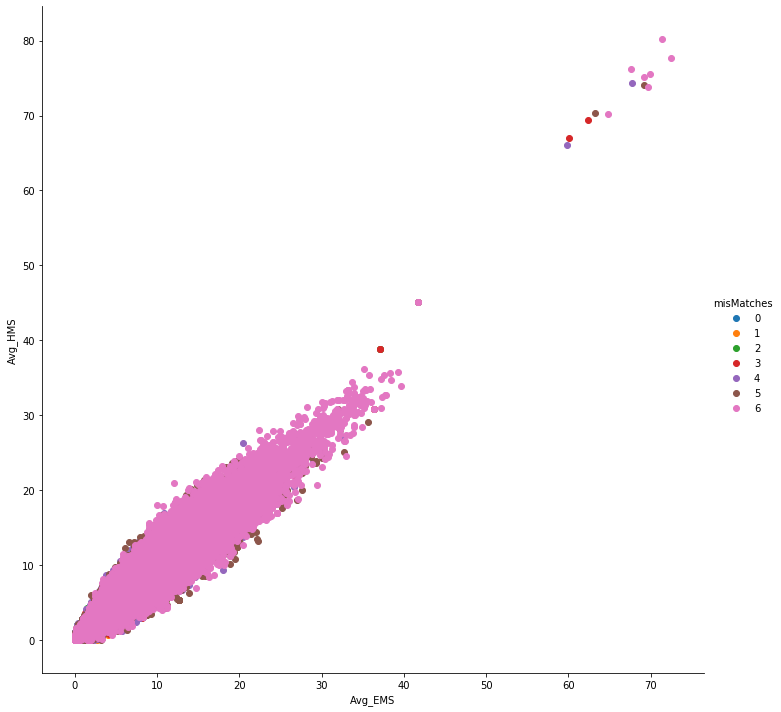

In [102]:
sns.FacetGrid(df,hue="misMatches", size=10).map(plt.scatter, "Avg_EMS", "Avg_HMS").add_legend()

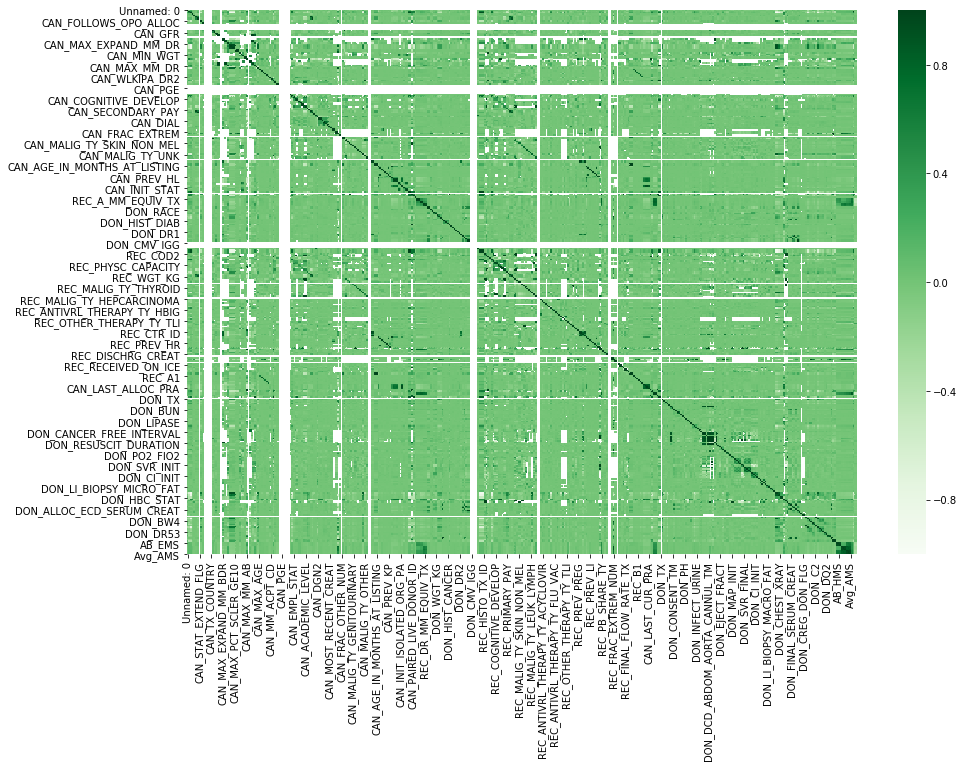

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap=plt.cm.Greens)
plt.show()

In [13]:
cor_target = abs(df.corr()["misMatches"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25]
relevant_features

REC_A_MM_EQUIV_TX            0.674319
REC_A_MM_EQUIV_CUR           0.660681
REC_B_MM_EQUIV_TX            0.709369
REC_B_MM_EQUIV_CUR           0.697933
REC_DR_MM_EQUIV_TX           0.629259
REC_DR_MM_EQUIV_CUR          0.605231
DON_ORG_SHARED               0.324360
REC_PB_SHARE_TY              0.680944
REC_FRAC_EXTREM_NUM          0.322413
REC_MM_EQUIV_TX              0.856316
REC_MM_EQUIV_CUR             0.863389
DON_COLD_ISCH_TM_ARRIV_KI    0.432115
AB_EMS                       0.381814
AB_HMS                       0.392484
AB_AMS                       0.432787
DR_EMS                       0.421412
DR_HMS                       0.422068
DR_AMS                       0.468181
Avg_EMS                      0.519449
Avg_HMS                      0.527324
Avg_AMS                      0.575195
misMatches                   1.000000
misMatches_binary            0.660217
Name: misMatches, dtype: float64

### Create a list of all the unneccessay columns which we drop at once 

In [184]:
allDropList = []

#### Drop all race columns to avoid racial bias. Also drop various IDs, as well as C and DQ allele information, as only A, B, and DR are used in mismatch calculation 

In [185]:
dropList = []

for column in Binary.columns:
    if 'High' in column or'RACE' in column or 'PERS_ID' in column or '_STATE' in column or '_ID' in column or 'DON_ID' in column or 'REC_ID' in column or 'PX_ID' in column or 'Unnamed' in column or '_C1' in column or '_C2' in column or '_DQ1' in column or '_DQ2' in column or 'HIGH' in column or '_DT' in column:
        dropList.append(column)


In [186]:
colList80 = []
# colList90 = []
# colList95 = []
for column in Binary.columns:
    if Binary[column].isnull().sum() * 100 / len(Binary) > 80:
        colList80.append(column)
#     if Binary[column].isnull().sum() * 100 / len(Binary) > 90:
#         colList90.append(column)
#     if Binary[column].isnull().sum() * 100 / len(Binary) > 95:
#         colList95.append(column)

print(len(colList80))
# print(len(colList90))
# print(len(colList95))

199


In [187]:
# Add the dropList and colList and our extra variables to the allDropList
allDropList = dropList
allDropList.extend(colList80)
allDropList.extend(["CAN_DGN_OSTXT", "REC_DGN_OSTXT", "TFL_LAFUDATE", "PERS_NEXTTX", "PERS_RELIST", "TFL_ENDTXFU"])

In [188]:
print(len(allDropList)) 

294


#### Drop every column from the all drop list to get the final dataframe

In [189]:
finalDF = Binary.drop(allDropList, axis = 1)

#### Fill missing values

In [190]:
for column in finalDF.columns:
    finalDF[column]=finalDF[column].fillna(method='ffill')
finalDF = finalDF.dropna()

yDummy = finalDF.misMatches_binary
finalDF = finalDF.drop('misMatches_binary', axis=1)

In [191]:
print_df_percent_missing(finalDF)

WL_ORG                         0.00%  Missing   1
CAN_GENDER                     0.00%  Missing   2
CAN_ABO                        0.00%  Missing   3
CAN_ETHNICITY_SRTR             0.00%  Missing   4
DON_TY                         0.00%  Missing   5
REC_TX_PROCEDURE_TY            0.00%  Missing   6
CAN_MOST_RECENT_HGT_CM         0.00%  Missing   7
CAN_MOST_RECENT_WGT_KG         0.00%  Missing   8
CAN_STAT_EXTEND_FLG            0.00%  Missing   9
CAN_FOLLOWS_OPO_ALLOC          0.00%  Missing   10
CAN_SOURCE                     0.00%  Missing   11
CAN_REM_CD                     0.00%  Missing   12
CAN_ANESTH_PRIOR_DEATH         0.00%  Missing   13
CAN_ANASTOMOSIS                0.00%  Missing   14
CAN_ON_DIAL                    0.00%  Missing   15
CAN_ON_EXPAND_DON_LIST         0.00%  Missing   16
CAN_MAX_EXPAND_MM_ABDR         0.00%  Missing   17
CAN_ACPT_HBC_POS               0.00%  Missing   18
CAN_MAX_WARM_TM                0.00%  Missing   19
CAN_MAX_COLD_TM                0.00%  Mi

In [192]:
print(finalDF.shape)

(158446, 353)


### Drop the columns which have object dtype (categorical columns) with too many unique values

In [112]:
data = {}
for i in finalDF.columns:
    if finalDF[i].dtype == "object":
        data[i] = len(finalDF[i].unique())
        #print(i, ": ", len(df[i].unique()))

print(sorted(data.items(), key=lambda x: x[1], reverse=True))
#len(df['CAN_DGN_OSTXT'].unique())

[('CAN_ABO', 9), ('DON_ABO', 9), ('REC_TX_ORG_TY', 8), ('DON_ANTI_CMV', 7), ('DON_ANTI_HCV', 7), ('REC_CUR_PX_STAT', 7), ('DON_ANTI_HIV', 7), ('DON_ANTI_HTLV', 7), ('DON_RPR_VDRL', 7), ('DON_HBV_SURF_ANTIGEN', 7), ('DON_ANTI_HBC', 7), ('DON_EBV_IGG', 7), ('DON_EBV_IGM', 7), ('DON_EBNA', 7), ('DON_HBV_SURF_ANTIBODY', 6), ('TFL_LASTATUS', 5), ('REC_TX_EXTRA_VESSEL', 4), ('REC_HIV_STAT', 4), ('REC_CMV_IGG', 4), ('REC_CMV_IGM', 4), ('REC_CMV_STAT', 4), ('REC_HBV_ANTIBODY', 4), ('REC_HBV_SURF_ANTIGEN', 4), ('REC_HCV_STAT', 4), ('REC_EBV_STAT', 4), ('WL_ORG', 3), ('CAN_WORK_INCOME', 3), ('CAN_NEW_PREV_PI_TX', 3), ('CAN_DRUG_TREAT_HYPERTEN', 3), ('CAN_CEREB_VASC', 3), ('CAN_PERIPH_VASC', 3), ('CAN_DRUG_TREAT_COPD', 3), ('CAN_PULM_EMBOL', 3), ('CAN_EXHAUST_VASC_ACCESS', 3), ('CAN_EXHAUST_PERIT_ACCESS', 3), ('CAN_PREV_TXFUS', 3), ('CAN_MALIG', 3), ('ORG_AR', 3), ('DON_DDAVP', 3), ('DON_DOPAMINE', 3), ('DON_DOBUTAMINE', 3), ('DON_INOTROP_SUPPORT', 3), ('DON_HIST_IV_DRUG', 3), ('DON_HIST_CIGARETT

#### Get dummies to deal with categorical data

In [193]:
XDummy = pd.get_dummies(finalDF, drop_first=True).astype(np.float32)

In [194]:
# Make sure the conversion into float 32 occurs
assert(XDummy.REC_TX_PROCEDURE_TY.dtype == 'float32')

In [115]:
print(XDummy.describe)

<bound method NDFrame.describe of         REC_TX_PROCEDURE_TY  CAN_MOST_RECENT_HGT_CM  CAN_MOST_RECENT_WGT_KG  \
63                    102.0              157.479996               59.874199   
64                    102.0              157.479996               59.874199   
65                    102.0              157.479996               59.874199   
66                    101.0              157.479996               59.874199   
67                    102.0              157.479996               59.874199   
68                    102.0              157.479996               59.874199   
69                    102.0              157.479996               59.874199   
70                    102.0              157.479996               59.874199   
71                    102.0              157.479996               59.874199   
72                    101.0              157.479996               59.874199   
73                    102.0              157.479996               59.874199   
74                

In [116]:
summary=XDummy.describe().transpose()
print(summary)

                                      count         mean         std      min  \
REC_TX_PROCEDURE_TY                158446.0   101.563515    0.567259  101.000   
CAN_MOST_RECENT_HGT_CM             158446.0   168.541824   15.864809    0.000   
CAN_MOST_RECENT_WGT_KG             158446.0    76.274574   21.255049    0.454   
CAN_STAT_EXTEND_FLG                158446.0     0.000000    0.000000    0.000   
CAN_FOLLOWS_OPO_ALLOC              158446.0     0.627722    0.483563    0.000   
CAN_REM_CD                         158446.0     4.059535    0.925959    4.000   
CAN_ANESTH_PRIOR_DEATH             158446.0     0.000000    0.000000    0.000   
CAN_ANASTOMOSIS                    158446.0     0.000000    0.000000    0.000   
CAN_ON_EXPAND_DON_LIST             158446.0     0.475948    0.499462    0.000   
CAN_MAX_EXPAND_MM_ABDR             158446.0     5.946752    0.516120    0.000   
CAN_MAX_WARM_TM                    158446.0   112.094040   68.540817    0.000   
CAN_MAX_COLD_TM             

#### Standardize data

In [195]:
scaler = StandardScaler()

In [196]:
scaler.fit(XDummy)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [197]:
xScaled = scaler.transform(XDummy)
xScaled

array([[ 0.76972366, -0.69757621, -0.77139548, ...,  0.08171577,
        -0.49582309, -0.22980716],
       [ 0.76972366, -0.69757621, -0.77139548, ...,  0.08171577,
        -0.49582309, -0.22980716],
       [ 0.76972366, -0.69757621, -0.77139548, ...,  0.08171577,
        -0.49582309, -0.22980716],
       ...,
       [-0.99374364,  0.58320061,  0.5943615 , ...,  0.08171577,
        -0.49582309, -0.22980716],
       [-0.99374364, -1.17786704, -0.42994071, ...,  0.08171577,
        -0.49582309, -0.22980716],
       [ 0.76972366, -0.377382  , -0.36591069, ...,  0.08171577,
        -0.49582309,  4.35147442]])

In [198]:
XScaledDF = pd.DataFrame(xScaled, columns=XDummy.columns)
XScaledDF.sample(10)

,REC_TX_PROCEDURE_TY,CAN_MOST_RECENT_HGT_CM,CAN_MOST_RECENT_WGT_KG,CAN_STAT_EXTEND_FLG,CAN_FOLLOWS_OPO_ALLOC,CAN_REM_CD,CAN_ANESTH_PRIOR_DEATH,CAN_ANASTOMOSIS,CAN_ON_EXPAND_DON_LIST,CAN_MAX_EXPAND_MM_ABDR,...,DON_PULM_CATH_Y,DON_LI_BIOPSY_U,DON_LI_BIOPSY_Y,DON_TM_FOR_XMATCH_Y,DON_ALLOC_REMAIN_LI_SEG_N,DON_ALLOC_REMAIN_LI_SEG_Y,DON_HLA_TYP_U,DON_HLA_TYP_Y,DON_PREV_GASTRO_DISEASE_U,DON_PREV_GASTRO_DISEASE_Y
76704,-0.993744,0.583201,0.252940,0.0,0.770106,-0.064232,0.0,0.0,1.049320,0.10314,...,-0.262622,1.385841,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,-0.229807
109815,-0.993744,0.903395,0.509014,0.0,-1.298523,-0.064232,0.0,0.0,-0.952999,0.10314,...,3.807752,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,2.016848,-0.229807
142810,-0.993744,0.583201,1.042522,0.0,-1.298523,-0.064232,0.0,0.0,1.049320,0.10314,...,-0.262622,-0.721583,2.001508,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,4.351474
8351,0.769724,0.583201,0.252940,0.0,-1.298523,-0.064232,0.0,0.0,1.049320,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,4.351474
115797,0.769724,1.863976,2.941754,0.0,0.770106,-0.064232,0.0,0.0,-0.952999,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,2.016848,-0.229807
14211,-0.993744,0.903395,-0.059779,0.0,0.770106,-0.064232,0.0,0.0,-0.952999,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,4.351474
138575,0.769724,-5.329045,-3.051940,0.0,-1.298523,-0.064232,0.0,0.0,-0.952999,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,-0.229807
111140,0.769724,0.743297,1.163432,0.0,-1.298523,-0.064232,0.0,0.0,-0.952999,0.10314,...,-0.262622,-0.721583,2.001508,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,-0.229807
146609,-0.993744,-0.377382,-0.451300,0.0,-1.298523,-0.064232,0.0,0.0,-0.952999,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,-0.229807
135932,0.769724,0.903395,2.152177,0.0,-1.298523,-0.064232,0.0,0.0,1.049320,0.10314,...,-0.262622,-0.721583,-0.499623,0.198045,-0.046373,-0.033818,-0.02384,0.081716,-0.495823,-0.229807


In [199]:
print("XDummy Shape:", XScaledDF.shape)
print("YDummy Shape: ", yDummy.shape)

XDummy Shape: (158446, 509)
YDummy Shape:  (158446,)


In [122]:
summary_transfrom=XScaledDF.describe().transpose()
print(summary_transfrom)

                                      count          mean       std  \
REC_TX_PROCEDURE_TY                158446.0 -3.898638e-14  1.000003   
CAN_MOST_RECENT_HGT_CM             158446.0  1.493159e-15  1.000003   
CAN_MOST_RECENT_WGT_KG             158446.0  1.022952e-14  1.000003   
CAN_STAT_EXTEND_FLG                158446.0  0.000000e+00  0.000000   
CAN_FOLLOWS_OPO_ALLOC              158446.0  6.981343e-14  1.000003   
CAN_REM_CD                         158446.0 -2.119152e-14  1.000003   
CAN_ANESTH_PRIOR_DEATH             158446.0  0.000000e+00  0.000000   
CAN_ANASTOMOSIS                    158446.0  0.000000e+00  0.000000   
CAN_ON_EXPAND_DON_LIST             158446.0  1.017872e-14  1.000003   
CAN_MAX_EXPAND_MM_ABDR             158446.0 -1.666229e-14  1.000003   
CAN_MAX_WARM_TM                    158446.0 -1.502102e-14  1.000003   
CAN_MAX_COLD_TM                    158446.0 -1.432145e-13  1.000003   
CAN_MAX_PCT_SCLER_LT10             158446.0  7.727090e-14  1.000003   
CAN_MA

# Feature selection using random forest (1000 trees)

In [200]:
Xtrain, Xtest, ytrain, ytest = train_test_split(XScaledDF, yDummy, test_size=0.2, random_state=0)

In [201]:
clf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0, n_jobs=-1)

In [202]:
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [203]:
yPred = clf.predict(Xtest)

In [62]:
mapped=zip(clf.feature_importances_, XScaledDF.columns)
mapped = set(mapped)
sortedList = sorted(mapped)[::-1]
sortedList[:-1]

[(0.08867398085236942, 'REC_MM_EQUIV_CUR'),
 (0.05016895550296894, 'REC_B_MM_EQUIV_CUR'),
 (0.0383687039942436, 'REC_A_MM_EQUIV_CUR'),
 (0.03764990718161894, 'REC_MM_EQUIV_TX'),
 (0.03559458286844183, 'Avg_AMS'),
 (0.033185844279122745, 'Avg_HMS'),
 (0.029644855260021082, 'REC_DR_MM_EQUIV_CUR'),
 (0.02888654464933148, 'Avg_EMS'),
 (0.02123287148141695, 'REC_B_MM_EQUIV_TX'),
 (0.018453471377658563, 'DR_EMS'),
 (0.016839895637335612, 'AB_AMS'),
 (0.01642682697312013, 'DR_HMS'),
 (0.016264654778910047, 'REC_A_MM_EQUIV_TX'),
 (0.01594445716556275, 'DR_AMS'),
 (0.015500292650708732, 'DON_DR1'),
 (0.015438594279317059, 'AB_HMS'),
 (0.01488226979679486, 'DON_DR2'),
 (0.01382424791577395, 'AB_EMS'),
 (0.011619067234940494, 'REC_DR1'),
 (0.010235839566386786, 'DON_ORG_SHARED'),
 (0.009373033033080774, 'REC_DR_MM_EQUIV_TX'),
 (0.009361046139726999, 'CAN_WLKIPA_DR1'),
 (0.008286967693088223, 'DON_B2'),
 (0.007747164263248523, 'REC_DR2'),
 (0.007622258578614942, 'DON_A2'),
 (0.00703443435838004, '

Feature ranking:
1. feature 162 (0.088674)
2. feature 81 (0.050169)
3. feature 79 (0.038369)
4. feature 161 (0.037650)
5. feature 235 (0.035595)
6. feature 234 (0.033186)
7. feature 83 (0.029645)
8. feature 233 (0.028887)
9. feature 80 (0.021233)
10. feature 230 (0.018453)
11. feature 229 (0.016840)
12. feature 231 (0.016427)
13. feature 78 (0.016265)
14. feature 232 (0.015944)
15. feature 100 (0.015500)
16. feature 228 (0.015439)
17. feature 101 (0.014882)
18. feature 227 (0.013824)
19. feature 154 (0.011619)
20. feature 129 (0.010236)
21. feature 82 (0.009373)
22. feature 25 (0.009361)
23. feature 99 (0.008287)
24. feature 155 (0.007747)
25. feature 97 (0.007622)
26. feature 98 (0.007034)
27. feature 152 (0.007017)
28. feature 26 (0.006833)
29. feature 153 (0.006106)
30. feature 23 (0.005734)
31. feature 24 (0.005288)
32. feature 185 (0.004848)
33. feature 226 (0.004729)
34. feature 151 (0.004693)
35. feature 142 (0.004648)
36. feature 22 (0.004568)
37. feature 84 (0.004560)
38. feat

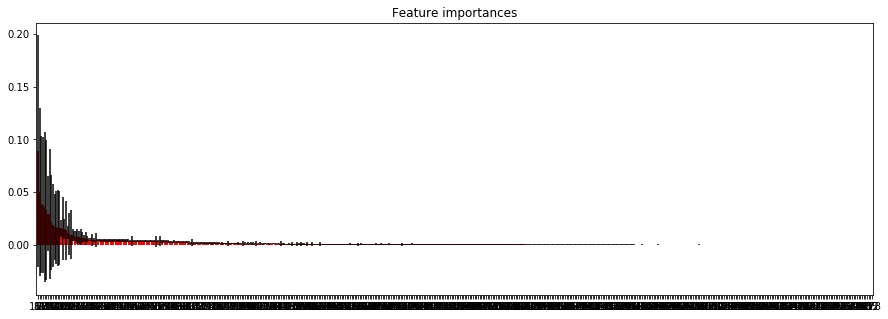

In [63]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=[15,5])
#plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [204]:
sfm_rf = SelectFromModel(clf, threshold=0.01)
model_rf=sfm_rf.fit(Xtrain, ytrain.values.ravel())   
 
# Printing the names of the most important features
for feature_list_index in sfm_rf.get_support(indices=True):
    print( XScaledDF.columns[feature_list_index])

REC_A_MM_EQUIV_TX
REC_A_MM_EQUIV_CUR
REC_B_MM_EQUIV_TX
REC_B_MM_EQUIV_CUR
REC_DR_MM_EQUIV_CUR
DON_DR1
DON_DR2
DON_ORG_SHARED
REC_DR1
REC_MM_EQUIV_TX
REC_MM_EQUIV_CUR
AB_EMS
AB_HMS
AB_AMS
DR_EMS
DR_HMS
DR_AMS
Avg_EMS
Avg_HMS
Avg_AMS


# Classification using random forest for selected features (1000 trees)

In [205]:
X_best_train_rf = sfm_rf.transform(Xtrain)
X_best_test_rf = sfm_rf.transform(Xtest)

In [206]:
clf_best_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0, n_jobs=-1)

In [207]:
clf_best_rf.fit(X_best_train_rf,ytrain.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

Feature ranking:
1. feature 10 (0.182628)
2. feature 8 (0.098657)
3. feature 19 (0.078833)
4. feature 3 (0.075302)
5. feature 5 (0.074826)
6. feature 6 (0.070838)
7. feature 18 (0.069529)
8. feature 17 (0.060661)
9. feature 1 (0.043219)
10. feature 9 (0.042270)
11. feature 4 (0.036383)
12. feature 14 (0.023120)
13. feature 15 (0.020883)
14. feature 11 (0.020755)
15. feature 2 (0.020283)
16. feature 12 (0.020195)
17. feature 16 (0.019622)
18. feature 13 (0.019399)
19. feature 0 (0.012729)
20. feature 7 (0.009870)


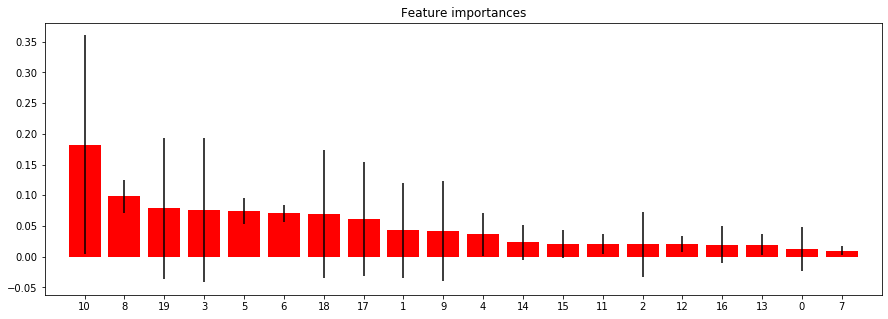

In [242]:
importances_best_rf = clf_best_rf.feature_importances_
std_best_rf = np.std([tree.feature_importances_ for tree in clf_best_rf.estimators_],
             axis=0)
indices_best_rf = np.argsort(importances_best_rf)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_best_train_rf.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_best_rf[f], importances_best_rf[indices_best_rf[f]]))

# Plot the feature importances of the forest
fig=plt.figure(figsize=[15,5])
#plt.figure()
plt.title("Feature importances")
plt.bar(range(X_best_train_rf.shape[1]), importances_best_rf[indices_best_rf],
       color="r", yerr=std_best_rf[indices_best_rf], align="center")
plt.xticks(range(X_best_train_rf.shape[1]), indices_best_rf)
plt.xlim([-1, X_best_train_rf.shape[1]])
#plt.show()
plt.savefig('feature.png')
fig.savefig('FI.png')

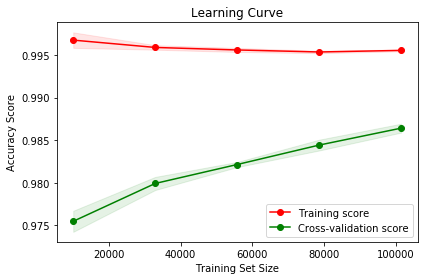

In [243]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X_best_train_rf, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
plt.plot(train_sizes, test_mean,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
#plt.show()
plt.savefig('LC_rf.png')

In [132]:
y_best_pred_rf = clf_best_rf.predict(X_best_test_rf)
y_train_pred_rf = clf_best_rf.predict(X_best_train_rf)
print("Full model OBB score:", clf.oob_score_)
print("Full model accuracy for test data:",accuracy_score(yPred,ytest))
print('Full model Kappa accuracy for test data:', cohen_kappa_score(ytest,yPred))
print("Full model F1 score for test data: ", f1_score(yPred,ytest)) 
print("Full model balanced accuracy for test data:", balanced_accuracy_score(ytest, yPred))
print("Model with selective features OBB score:", clf_best_rf.oob_score_)
print('Kappa accuracy on selected features for training data:', cohen_kappa_score(ytrain, y_train_pred_rf))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest, y_best_pred_rf))
print('Accuracy on selected features for training data:',accuracy_score(ytrain, y_train_pred_rf))
print("Accuracy on selected features for for test data:", accuracy_score(ytest, y_best_pred_rf))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain, y_train_pred_rf))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest, y_best_pred_rf))
print("Model with selective features F1 score for training data:: ", f1_score(y_train_pred_rf,ytrain))
print("Model with selective features F1 score for test data:", f1_score(y_best_pred_rf,ytest))   
print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_best_rf,X_best_train_rf, ytrain, cv=5,scoring='roc_auc')))
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,X_best_test_rf, ytest, cv=5,scoring='roc_auc')))

Full model OBB score: 0.9871643156931428
Full model accuracy for test data: 0.9871252761123382
Full model Kappa accuracy for test data: 0.8688288319290227
Full model F1 score for test data:  0.875609756097561
Full model balanced accuracy for test data: 0.9213485450165493
Model with selective features OBB score: 0.9889314904225441
Kappa accuracy on selected features for training data: 0.9623225690194949
Kappa accuracy on selected features for test data: 0.8955322262354388
Accuracy on selected features for training data: 0.9959370759569567
Accuracy on selected features for for test data: 0.989113284947933
Balanced accuracy on selected features for training data: 0.9943745996588207
Balanced accuracy on selected features for test data: 0.9611088641019905
Model with selective features F1 score for training data::  0.9644754087052493
Model with selective features F1 score for test data: 0.9012875536480687
5-fold cross-validation score on selected features for training  data: 0.99685626646364

In [133]:
confusion_matrix1 = confusion_matrix(ytest, y_best_pred_rf)
print(confusion_matrix1)

[[29770   226]
 [  119  1575]]


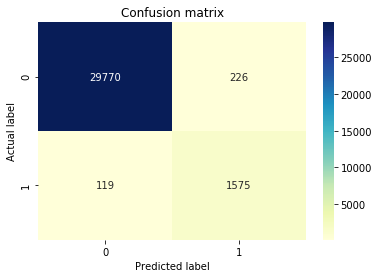

In [244]:
sns.heatmap(confusion_matrix1, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
""" Confusion matrix fix taken from github"""
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show() # ta-da!
plt.savefig('cf_rf.png')

In [209]:
y_score1 = clf_best_rf.predict_proba(X_best_test_rf)[:,1]
print(y_score1)

[0. 0. 0. ... 0. 0. 0.]


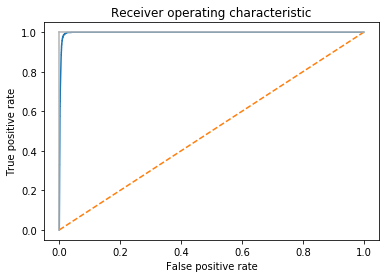

In [245]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_score1)

# Plot ROC curve
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
#plt.show()
plt.savefig('ROC_rf.png')

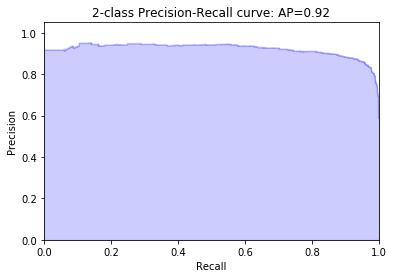

In [246]:
average_precision = average_precision_score(ytest, y_score1)

precision, recall, _ = precision_recall_curve(ytest, y_score1)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('PC_rf.png')

# Feature selection using random forest(10000 trees)

In [ ]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(XDummy, yDummy, test_size=0.2, random_state=0)

In [ ]:
clf2 = RandomForestClassifier(n_estimators=10000, oob_score=True, random_state=0, n_jobs=-1)

In [ ]:
clf2.fit(Xtrain2, ytrain2) #Double check 

In [ ]:
yPred2 = clf2.predict(Xtest2)

In [ ]:
mapped2=zip(clf2.feature_importances_, XDummy.columns)
mapped2 = set(mapped2)
sortedList2 = sorted(mapped2)[::-1]
sortedList2[:-1]

In [ ]:
sfm_rf2 = SelectFromModel(clf2, threshold=0.01)
model_rf2=sfm_rf2.fit(Xtrain2, ytrain2.values.ravel())   
 
# Printing the names of the most important features
for feature_list_index in sfm_rf2.get_support(indices=True):
    print( XDummy.columns[feature_list_index])

# Classification using random forest for selected features (10000 trees)

In [ ]:
X_best_train_rf2 = sfm_rf2.transform(Xtrain2)
X_best_test_rf2 = sfm_rf2.transform(Xtest2)

In [ ]:
clf_best2 = RandomForestClassifier(n_estimators=10000, oob_score=True, random_state=0, n_jobs=-1)

In [ ]:
clf_best2.fit(X_best_train_rf2,ytrain2.values.ravel())

In [ ]:
importances_best_rf2 = clf_best2.feature_importances_
std_best_rf2 = np.std([tree.feature_importances_ for tree in clf_best2.estimators_],
             axis=0)
indices_best_rf2 = np.argsort(importances_best_rf2)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_best_train_rf2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_best_rf2[f], importances_best_rf2[indices_best_rf2[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=[15,5])
#plt.figure()
plt.title("Feature importances")
plt.bar(range(X_best_train_rf2.shape[1]), importances_best_rf2[indices_best_rf2],
       color="r", yerr=std_best_rf2[indices_best_rf2], align="center")
plt.xticks(range(X_best_train_rf2.shape[1]), indices_best_rf2)
plt.xlim([-1, X_best_train_rf2.shape[1]])
plt.show()

In [ ]:
y_best_pred_rf2 = clf_best2.predict(X_best_test_rf2)
y_train_pred_rf2 =clf_best2.predict(X_best_train_rf2)
print("Full model OBB score:", clf2.oob_score_)
print("Full model accuracy for test data:",accuracy_score(yPred2,ytest2))
print("Full model F1 score for test data: ", f1_score(yPred2,ytest2)) 
print("Full model balanced accuracy for test data::", balanced_accuracy_score(ytest2, yPred2))
print('Kappa accuracy on selected features for training data:', cohen_kappa_score(ytrain2, y_train_pred_rf2))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest2, y_best_pred_rf2))
print('Accuracy on selected features for training data:',accuracy_score(ytrain2, y_train_pred_rf2))
print("Accuracy on selected features for for test data:", accuracy_score(ytest2, y_best_pred_rf2))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain2, y_train_pred_rf2))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest2, y_best_pred_rf2))
print("Model with selective features F1 score for training  data:", f1_score(y_train_pred_rf2,ytrain2))  
print("Model with selective features F1 for test data score", f1_score(y_best_pred_rf2,ytest2)) 
print("Model with selective features OBB score:",clf_best2.oob_score_)
print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_best2,X_best_train_rf2,ytrain2, cv=5,scoring='roc_auc')))
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best2,X_best_test_rf2,ytest2, cv=5,scoring='roc_auc')))

In [ ]:
# Create CV training and test scores for various training set sizes
train_sizes2, train_scores2, test_scores2 = learning_curve(RandomForestClassifier(), 
                                                        X_best_train_rf2, 
                                                        ytrain2,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)

# Create means and standard deviations of test set scores
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)

# Draw lines
plt.plot(train_sizes2, train_mean2, 'o-', color="r",  label="Training score")
plt.plot(train_sizes2, test_mean2,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes2, train_mean2 - train_std2, train_mean2 + train_std2, alpha=0.1, color="r")
plt.fill_between(train_sizes2, test_mean2 - test_std2, test_mean2 + test_std2,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
confusion_matrix2 = confusion_matrix(ytest2, y_best_pred_rf2)
print(confusion_matrix2)

In [ ]:
print(type(confusion_matrix2))

In [ ]:
sns.heatmap(confusion_matrix2, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

""" Confusion matrix fix taken from github"""
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [ ]:
y_score2 = clf_best2.predict_proba(X_best_test_rf2)[:,1]

In [ ]:
# Create true and false positive rates
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(ytest2, y_score2)

# Plot ROC curve
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [ ]:
average_precision2 = average_precision_score(ytest2, y_score2)

precision2, recall2, _ = precision_recall_curve(ytest2, y_score2)

plt.step(recall2, precision2, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision2))

In [229]:
auc_RF1 = roc_auc_score(ytest, y_best_pred_rf)
auc_lr = roc_auc_score(ytest, y_best_pred_lr)
auc_nn = roc_auc_score(ytest, y_score_gs_nn)
print('AUC RF:%.3f'% auc_RF1)
print('AUC NN:%.3f'% auc_nn)
print('AUC LR:%.3f'% auc_lr)


AUC RF:0.961
AUC NN:0.995
AUC LR:0.837


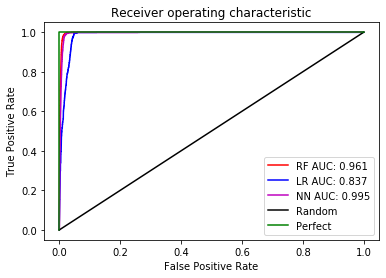

In [247]:
# Plot ROC curve
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate, true_positive_rate,'r-',label = 'RF AUC: %.3f'%auc_RF1)
plt.plot(false_positive_rate_lr, true_positive_rate_lr,'b-', label= 'LR AUC: %.3f'%auc_lr)
plt.plot(false_positive_rate_gs_nn, true_positive_rate_gs_nn,'m-', label= 'NN AUC: %.3f'%auc_nn)
plt.plot([0,1],[0,1],'k-',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='Perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.show()
plt.savefig('ROC_lr_nn_rf.png')

# Classification using logistic regression on selected features

In [212]:
# clf_lr = LogisticRegressionCV(cv=5,max_iter=1000,solver='lbfgs', random_state=0)
clf_lr = LogisticRegressionCV(Cs=100, cv=5,max_iter=4000,solver='lbfgs', random_state=0)

In [213]:
clf_lr.fit(X_best_train_rf, ytrain)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=4000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=0, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

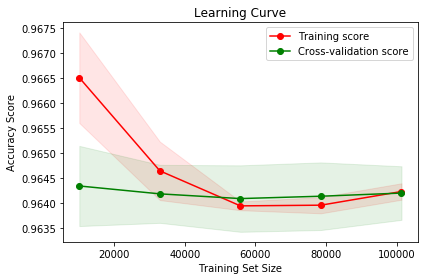

In [248]:
# Create CV training and test scores for various training set sizes
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(clf_lr, 
                                                        X_best_train_rf, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean_lr = np.mean(train_scores_lr, axis=1)
train_std_lr = np.std(train_scores_lr, axis=1)

# Create means and standard deviations of test set scores
test_mean_lr = np.mean(test_scores_lr, axis=1)
test_std_lr = np.std(test_scores_lr, axis=1)

# Draw lines
plt.plot(train_sizes_lr, train_mean_lr, 'o-', color="r",  label="Training score")
plt.plot(train_sizes_lr, test_mean_lr,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, alpha=0.1, color="r")
plt.fill_between(train_sizes_lr, test_mean_lr - test_std_lr, test_mean_lr + test_std_lr,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
#plt.show()
plt.savefig('LC_lr.png')

In [214]:
y_best_pred_lr = clf_lr.predict(X_best_test_rf)
y_train_pred_lr = clf_lr.predict(X_best_train_rf)

In [231]:
print('Kappa accuracy on selected features for training data:',cohen_kappa_score(ytrain, y_train_pred_lr))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest, y_best_pred_lr))
print('Accuracy on selected features for training data:',accuracy_score(ytrain, y_train_pred_lr))
print("Accuracy on selected features for for test data:", accuracy_score(ytest, y_best_pred_lr))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain, y_train_pred_lr))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest, y_best_pred_lr))
print("Model with selective features F1 score for training data: ", f1_score( y_train_pred_lr,ytrain))  
print("Model with selective features F1 score for test data: ", f1_score( y_best_pred_lr,ytest))   
print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_lr,X_best_train_rf, ytrain, cv=5,scoring='roc_auc')))
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_lr,X_best_test_rf, ytest,cv=5,scoring='roc_auc')))

Kappa accuracy on selected features for training data: 0.6646816977716121
Kappa accuracy on selected features for test data: 0.6645285070520646
Accuracy on selected features for training data: 0.964262046767017
Accuracy on selected features for for test data: 0.965541180183023
Balanced accuracy on selected features for training data: 0.8374925541161788
Balanced accuracy on selected features for test data: 0.8372610051273267
Model with selective features F1 score for training data:  0.6836150300321274
Model with selective features F1 score for test data:  0.6827425915165601
5-fold cross-validation score on selected features for training  data: 0.9846961141713979
5-fold cross-validation score on selected features for test data: 0.9850347044930612


In [145]:
confusion_matrix_lr= confusion_matrix(ytest, y_best_pred_lr)
print(confusion_matrix_lr)

[[29423   573]
 [  519  1175]]


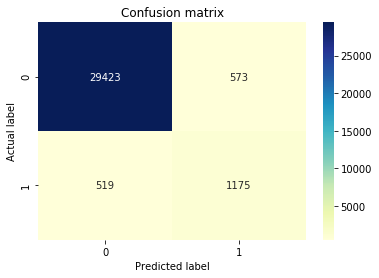

In [249]:
sns.heatmap(confusion_matrix_lr, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

""" Confusion matrix fix taken from github"""
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show() # ta-da!
plt.savefig('cf_lr.png')

In [215]:
y_score_lr = clf_lr.predict_proba(X_best_test_rf)[:,1]

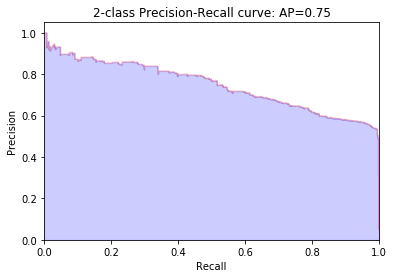

In [250]:
average_precision_lr = average_precision_score(ytest, y_score_lr)

precision_lr, recall_lr, _ = precision_recall_curve(ytest, y_score_lr)

plt.step(recall_lr, precision_lr, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_lr, precision_lr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_lr))
plt.savefig('pr_lr.png')


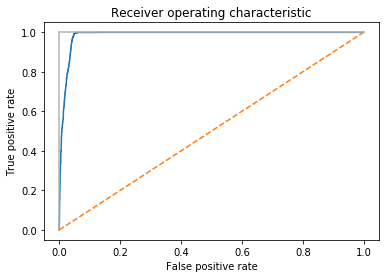

In [251]:
# Create true and false positive rates
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(ytest, y_score_lr)

# Plot ROC curve
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate_lr, true_positive_rate_lr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
#plt.show()
plt.savefig('roc_lr.png')

In [159]:
lr = LogisticRegressionCV()

In [160]:
parameter_space_lr = {
    'Cs' : [1,10,100,1000],
    'max_iter':[100,200,500,5000],
    'solver': ['newton-cg', 'lbfgs', 'lbfgs','liblinear','sag','saga']
}

#### Use Grid Search to help tune hyperparameters

In [161]:
clf_gs_lr = GridSearchCV(lr, parameter_space_lr, n_jobs=-1, cv=5)

In [162]:
clf_gs_lr.fit(X_best_train_rf, ytrain)

/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv='warn',
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1.0,
                                            l1_ratios=None, max_iter=100,
                                            multi_class='warn', n_jobs=None,
                                            penalty='l2', random_state=None,
                                            refit=True, scoring=None,
                                            solver='lbfgs', tol=0.0001,
                                            verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'Cs': [1, 10, 100, 1000],
                         'max_iter': [100, 200, 500, 5000],
                         'solver': ['newton-cg', 'lbfgs', 'lbfgs', 'liblinear',
                                    'sag', 'saga']},
             pre_d

In [163]:
clf_gs_lr.best_estimator_

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='sag', tol=0.0001, verbose=0)

In [168]:
clf_gs_lr2=LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='sag', tol=0.0001, verbose=0)

In [169]:
clf_gs_lr2.fit(X_best_train_rf, ytrain)

/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='sag', tol=0.0001, verbose=0)

In [170]:
y_best_pred_gs_lr = clf_gs_lr2.predict(X_best_test_rf)
y_train_pred_gs_lr = clf_gs_lr2.predict(X_best_train_rf)

In [171]:
print('Kappa accuracy on selected features for training data:',cohen_kappa_score(ytrain, y_train_pred_gs_lr))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest, y_best_pred_gs_lr))
print('Accuracy on selected features for training data:',accuracy_score(ytrain,y_train_pred_gs_lr))
print("Accuracy on selected features for for test data:", accuracy_score(ytest,y_best_pred_gs_lr))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain,y_train_pred_gs_lr))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest,y_best_pred_gs_lr))
print("Model with selective features F1 score: ", f1_score(y_train_pred_gs_lr,ytrain))   
print("Model with selective features F1 score: ", f1_score(y_best_pred_gs_lr,ytest))   
print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_gs_lr2,X_best_train_rf, ytrain, cv=5,scoring='roc_auc')))
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_gs_lr2,X_best_test_rf, ytest,cv=5,scoring='roc_auc')))
#Something is wrong with this line, but I am not sure what..
#print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_gs_lr2, X_best_test_rf, ytest, cv=5,scoring='roc_auc')))

Kappa accuracy on selected features for training data: 0.6643569828987306
Kappa accuracy on selected features for test data: 0.6647750284186336
Accuracy on selected features for training data: 0.9642462684212187
Accuracy on selected features for for test data: 0.9656042915746292
Balanced accuracy on selected features for training data: 0.8371501217096962
Balanced accuracy on selected features for test data: 0.8370158524088139
Model with selective features F1 score:  0.683298392732355
Model with selective features F1 score:  0.682955206515416


/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
cohen_kappa_score(ytest,y_best_pred_gs_lr)

In [ ]:
# Create CV training and test scores for various training set sizes
train_sizes_gs_lr, train_scores_gs_lr, test_scores_gs_lr = learning_curve(clf_gs_lr2, 
                                                        X_best_train_rf, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                       # cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean_gs_lr = np.mean(train_scores_gs_lr, axis=1)
train_std_gs_lr = np.std(train_scores_gs_lr, axis=1)

# Create means and standard deviations of test set scores
test_mean_gs_lr = np.mean(test_scores_gs_lr, axis=1)
test_std_gs_lr= np.std(test_scores_gs_lr, axis=1)

# Draw lines
plt.plot(train_sizes_gs_lr, train_mean_gs_lr, 'o-', color="r",  label="Training score")
plt.plot(train_sizes_gs_lr, test_mean_gs_lr,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_gs_lr, train_mean_gs_lr - train_std_gs_lr, train_mean_gs_lr + train_std_gs_lr, alpha=0.1, color="r")
plt.fill_between(train_sizes_gs_lr, test_mean_gs_lr - test_std_gs_lr, test_mean_gs_lr + test_std_gs_lr,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# Create CV training and test scores for various training set sizes
train_sizes_gs_lr, train_scores_gs_lr, test_scores_gs_lr = learning_curve(clf_gs_lr2, 
                                                        X_best_train_rf, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='roc_auc',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean_gs_lr = np.mean(train_scores_gs_lr, axis=1)
train_std_gs_lr = np.std(train_scores_gs_lr, axis=1)

# Create means and standard deviations of test set scores
test_mean_gs_lr = np.mean(test_scores_gs_lr, axis=1)
test_std_gs_lr= np.std(test_scores_gs_lr, axis=1)

# Draw lines
plt.plot(train_sizes_gs_lr, train_mean_gs_lr, 'o-', color="r",  label="Training score")
plt.plot(train_sizes_gs_lr, test_mean_gs_lr,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_gs_lr, train_mean_gs_lr - train_std_gs_lr, train_mean_gs_lr + train_std_gs_lr, alpha=0.1, color="r")
plt.fill_between(train_sizes_gs_lr, test_mean_gs_lr - test_std_gs_lr, test_mean_gs_lr + test_std_gs_lr,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Classification using neural network on selected features

In [150]:
clf_nn = MLPClassifier(solver='lbfgs', alpha=.2, hidden_layer_sizes=(20,20,20))

In [151]:
clf_nn.fit(X_best_train_rf, ytrain)

MLPClassifier(activation='relu', alpha=0.2, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [152]:
y_best_pred_nn = clf_nn.predict(X_best_test_rf)
y_train_pred_nn = clf_nn.predict(X_best_train_rf)

In [165]:
print('Kappa accuracy on selected features for training data:',cohen_kappa_score(ytrain, y_train_pred_nn))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest, y_best_pred_nn))
print('Accuracy on selected features for training data:',accuracy_score(ytrain,y_train_pred_nn))
print("Accuracy on selected features for for test data:", accuracy_score(ytest,y_best_pred_nn))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain,y_train_pred_nn))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest,y_best_pred_nn))
print("Model with selective features F1 score: ", f1_score(y_train_pred_nn,ytrain))   
print("Model with selective features F1 score: ", f1_score(y_best_pred_nn,ytest))   
print("Test balanced accuracy:", balanced_accuracy_score(ytest, y_best_pred_nn))
print("F1 score: ", f1_score(y_best_pred_nn,ytest))   
#print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_nn,X_best_train_rf, ytrain, cv=5)))
#print('5-fold cross-validation score on selected features for test data:',  np.mean(cross_val_score(clf_nn, X_best_test_rf, ytest,cv=5)))

Kappa accuracy on selected features for training data: 0.6783472375849838
Kappa accuracy on selected features for test data: 0.6736643092525454
Accuracy on selected features for training data: 0.9652087475149106
Accuracy on selected features for for test data: 0.9659829599242663
Balanced accuracy on selected features for training data: 0.8495528894969102
Balanced accuracy on selected features for test data: 0.8469630464699505
Model with selective features F1 score:  0.6967821782178218
Model with selective features F1 score:  0.6916475972540046
Test balanced accuracy: 0.8469630464699505
F1 score:  0.6916475972540046


In [154]:
confusion_matrix_nn= confusion_matrix(ytest, y_best_pred_nn)
print(confusion_matrix_nn)

[[29403   593]
 [  485  1209]]


In [166]:
clf_nn2 = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(39,39,39), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [167]:
clf_nn2.fit(X_best_train_rf, ytrain)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(39, 39, 39), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
y_best_pred_nn2 = clf_nn2.predict(X_best_test_rf)
y_train_pred_nn2 = clf_nn2.predict(X_best_train_rf)

In [ ]:
print('Accuracy on selected features for training data:',accuracy_score(ytrain, y_train_pred_nn2))
print("Accuracy on selected features for for test data:", accuracy_score(ytest, y_best_pred_nn2))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain, y_train_pred_nn2))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest, y_best_pred_nn2))
print("Model with selective features F1 score: ", f1_score( y_best_pred_nn2,ytest))   
#print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_nn2,X_best_train_rf, ytrain, cv=5)))
#print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_nn2,X_best_test_rf, ytest, cv=5)))

In [155]:
mlp = MLPClassifier(max_iter=200)

In [156]:
parameter_space = {
    'hidden_layer_sizes':  [(20,20,20),(20,),(19,19,19),(19,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001,0.001,0.01,.00001,0.1,0.5],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

#### Use Grid Search to Help tune Hyper parameters

In [157]:
clf_gs = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)

In [158]:
clf_gs.fit(X_best_train_rf, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 1e-05, 0.1, 0.5],
                         'hidden_layer_sizes': [(20, 20, 20), (20,),
                                                (19, 19, 19)

In [164]:
clf_gs.best_estimator_

MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [219]:
clf_gs_nn=MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [220]:
clf_gs_nn.fit(X_best_train_rf, ytrain)

MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [221]:
y_best_pred_gs_nn = clf_gs_nn.predict(X_best_test_rf)
y_train_pred_gs_nn = clf_gs_nn.predict(X_best_train_rf)

In [232]:
print('Kappa accuracy on selected features for training data:',cohen_kappa_score(ytrain,y_train_pred_gs_nn))
print('Kappa accuracy on selected features for test data:', cohen_kappa_score(ytest, y_best_pred_gs_nn))
print('Accuracy on selected features for training data:',accuracy_score(ytrain,y_train_pred_gs_nn))
print("Accuracy on selected features for for test data:", accuracy_score(ytest, y_best_pred_gs_nn))
print('Balanced accuracy on selected features for training data:', balanced_accuracy_score(ytrain, y_train_pred_gs_nn))
print("Balanced accuracy on selected features for test data:", balanced_accuracy_score(ytest, y_best_pred_gs_nn))
print("Model with selective features F1 score on test data: ", f1_score(y_best_pred_gs_nn,ytest)) 
print("Model with selective features F1 score on training: ", f1_score(y_train_pred_gs_nn,ytrain))    
print('5-fold cross-validation score on selected features for training  data:', np.mean(cross_val_score(clf_gs_nn,X_best_train_rf, ytrain, cv=5)))
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_gs_nn,X_best_test_rf, ytest, cv=5)))

Kappa accuracy on selected features for training data: 0.8798396589391584
Kappa accuracy on selected features for test data: 0.8569085089574592
Accuracy on selected features for training data: 0.9865884060715074
Accuracy on selected features for for test data: 0.9844430419690754
Balanced accuracy on selected features for training data: 0.9678437529692254
Balanced accuracy on selected features for test data: 0.9603128114838767
Model with selective features F1 score on test data:  0.8651162790697674
Model with selective features F1 score on training:  0.8869380154296355


/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5-fold cross-validation score on selected features for training  data: 0.9832592060786103


/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5-fold cross-validation score on selected features for test data: 0.9801831722114205


/home/kidneyFolk/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


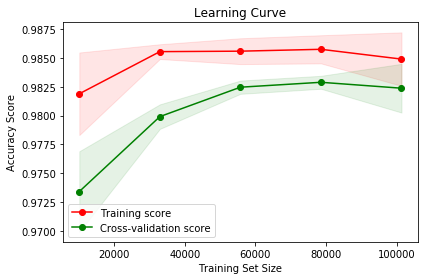

In [255]:
# Create CV training and test scores for various training set sizes
train_sizes_gs_nn, train_scores_gs_nn, test_scores_gs_nn = learning_curve(clf_gs_nn, 
                                                        X_best_train_rf, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean_gs_nn = np.mean(train_scores_gs_nn, axis=1)
train_std_gs_nn = np.std(train_scores_gs_nn, axis=1)

# Create means and standard deviations of test set scores
test_mean_gs_nn = np.mean(test_scores_gs_nn, axis=1)
test_std_gs_nn = np.std(test_scores_gs_nn, axis=1)

# Draw lines
plt.plot(train_sizes_gs_nn, train_mean_gs_nn, 'o-', color="r",  label="Training score")
plt.plot(train_sizes_gs_nn, test_mean_gs_nn,'o-',  color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_gs_nn, train_mean_gs_nn - train_std_gs_nn, train_mean_gs_nn + train_std_gs_nn, alpha=0.1, color="r")
plt.fill_between(train_sizes_gs_nn, test_mean_gs_nn - test_std_gs_nn, test_mean_gs_nn + test_std_gs_nn,alpha=0.1, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
#plt.show()
plt.savefig('lc_nn.png')

In [223]:
confusion_matrix_gs_nn = confusion_matrix(ytest, y_best_pred_gs_nn)
print(confusion_matrix_gs_nn)


[[29616   380]
 [  113  1581]]


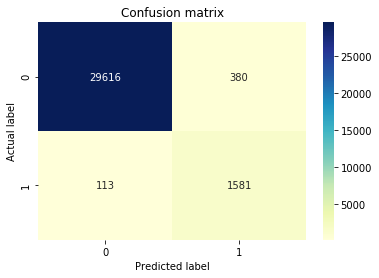

In [252]:
sns.heatmap(confusion_matrix_gs_nn, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
""" Confusion matrix fix taken from github"""
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show() # ta-da!
plt.savefig('cf_nn.png')

In [225]:
y_score_gs_nn =clf_gs_nn.predict_proba(X_best_test_rf)[:,1]

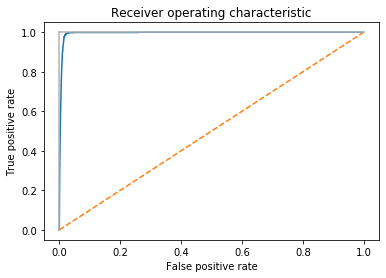

In [253]:
# Create true and false positive rates
false_positive_rate_gs_nn, true_positive_rate_gs_nn, threshold_gs_nn = roc_curve(ytest, y_score_gs_nn)

# Plot ROC curve
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate_gs_nn, true_positive_rate_gs_nn)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
#plt.show()
plt.savefig('roc_nn.png')

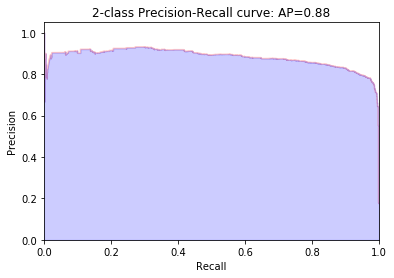

In [254]:
average_precision_nn = average_precision_score(ytest, y_score_gs_nn)

precision_nn, recall_nn, _ = precision_recall_curve(ytest, y_score_gs_nn)

plt.step(recall_nn, precision_nn, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_nn, precision_nn, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_nn))
plt.savefig('pr_nn.png')

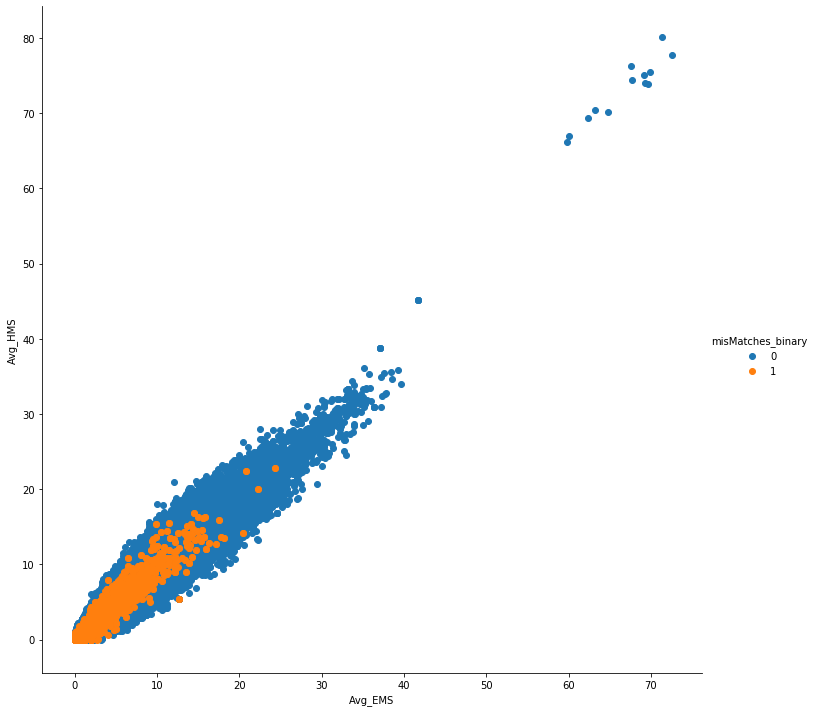

In [280]:
sns.FacetGrid(df,hue="misMatches_binary", height=10).map(plt.scatter, "Avg_EMS", "Avg_HMS").add_legend()